# Comparing 3D descriptors

We'll use the Platinum dataset from the ZBH in Hamburg: http://pubs.acs.org/doi/abs/10.1021/acs.jcim.6b00613


In [1]:
from collections import defaultdict
import numpy as np
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem.Draw import IPythonConsole
IPythonConsole.ipython_3d=True
import matplotlib as mpl
import matplotlib.pyplot as plt
plt.style.use('seaborn-notebook')
%pylab inline
import rdkit
print(rdkit.__version__)

Populating the interactive namespace from numpy and matplotlib
2021.03.1


Read the molecules in and assign atomic chirality based on the structures provided.

In [24]:
ms = [x for x in Chem.SDMolSupplier('../data/platinum_dataset_2017_01.sdf',removeHs=False)]
# Assign atomic chirality based on the structures:
for m in ms: Chem.AssignAtomChiralTagsFromStructure(m)
len(ms)

4548

# Conformation generation

Start by generating 100 conformations via ETKDG

# Descriptor calculation

In [2]:
import gzip,pickle
with open('../data/platinum_dataset_2017_01.confs.sretkdg3.pkl','rb') as inf:
    tms1 = pickle.load(inf)

In [3]:
from rdkit.Chem import rdMolDescriptors

In [6]:
mol = tms1[0]
conf = mol.GetConformer()

In [18]:
pts = conf.GetPositions()
cm = np.cov(pts.transpose())
vals,vecs = np.linalg.eig(cm)
vals = np.sort(vals)[::-1]
vals[-1]/vals[0]

0.06985385541844803

In [26]:
def CalcGlobularity(mol,confId=-1):
    """
    Calculates the globularity (glob) of a molecule

    glob varies from 0 to 1 with completely flat molecules like benzene having a
    glob of 0 and spherical molecules like adamantane having a glob of 1

    :param points: numpy array of atom coordinates
    :type points: numpy array
    :return: globularity of molecule
    :rtype: float | int
    """
    
    # calculate covariance matrix
    cov_mat = np.cov(mol.GetConformer(confId).GetPositions().transpose())

    # calculate eigenvalues of covariance matrix and sort
    vals, vecs = np.linalg.eig(cov_mat)
    vals = np.sort(vals)[::-1]

    # glob is ratio of last eigenvalue and first eigenvalue
    if vals[0] != 0:
        return vals[-1]/vals[0]
    else:
        return -1

In [27]:
l = [rdMolDescriptors.CalcPBF,rdMolDescriptors.CalcPMI1,rdMolDescriptors.CalcPMI2,rdMolDescriptors.CalcPMI3,
          rdMolDescriptors.CalcNPR1, rdMolDescriptors.CalcNPR2, rdMolDescriptors.CalcRadiusOfGyration, 
           rdMolDescriptors.CalcInertialShapeFactor, rdMolDescriptors.CalcAsphericity, 
           rdMolDescriptors.CalcEccentricity,rdMolDescriptors.CalcSpherocityIndex,CalcGlobularity]
descrs3d = dict((x.__name__.replace('Calc',''),x) for x in l)

In [28]:
from collections import defaultdict
accum3d = {}
for m,tm in zip(ms,tms1):
    nm = m.GetProp('_Name')
    laccum=defaultdict(list)
    for conf in tm.GetConformers():
        for descr in descrs3d:
            laccum[descr].append(descrs3d[descr](tm,confId=conf.GetId()))
    accum3d[nm] = laccum

In [29]:
import gzip,pickle
with open('../data/platinum_dataset_2017_01.descriptors.pkl','wb+') as outf:
    pickle.dump(accum3d,outf)

# Look at correlations between descriptors

In [30]:
descr_accum = defaultdict(list)
for k in accum3d:
    laccum = accum3d[k]
    for descr in laccum:
        descr_accum[descr].extend(laccum[descr])
all_accum = []
for v in descr_accum.values():
    all_accum.append(v)
all_accum = np.array(all_accum)

In [32]:
from scipy.stats import spearmanr
c,p = spearmanr(all_accum,axis=1)

In [33]:
dnms = list(descr_accum.keys())
for idx,row in enumerate(c):
    print(f'{idx:2d} {dnms[idx][:12]:12s}','\t'.join('%6.3f'%x for x in row))
print(' '*15,'\t'.join('%6d'%x for x in range(len(c))))

 0 PBF           1.000	 0.493	 0.259	 0.287	 0.230	-0.134	 0.229	-0.476	-0.232	-0.230	 0.095	 0.228
 1 PMI1          0.493	 1.000	 0.492	 0.604	 0.453	-0.463	 0.451	-0.993	-0.453	-0.453	 0.005	 0.156
 2 PMI2          0.259	 0.492	 1.000	 0.984	-0.496	 0.377	 0.975	-0.413	 0.496	 0.496	-0.407	-0.516
 3 PMI3          0.287	 0.604	 0.984	 1.000	-0.375	 0.234	 0.966	-0.533	 0.375	 0.375	-0.382	-0.471
 4 NPR1          0.230	 0.453	-0.496	-0.375	 1.000	-0.834	-0.524	-0.522	-1.000	-1.000	 0.458	 0.743
 5 NPR2         -0.134	-0.463	 0.377	 0.234	-0.834	 1.000	 0.356	 0.549	 0.836	 0.834	-0.260	-0.372
 6 RadiusOfGyra  0.229	 0.451	 0.975	 0.966	-0.524	 0.356	 1.000	-0.377	 0.524	 0.524	-0.460	-0.576
 7 InertialShap -0.476	-0.993	-0.413	-0.533	-0.522	 0.549	-0.377	 1.000	 0.522	 0.522	-0.032	-0.189
 8 Asphericity  -0.232	-0.453	 0.496	 0.375	-1.000	 0.836	 0.524	 0.522	 1.000	 1.000	-0.460	-0.744
 9 Eccentricity -0.230	-0.453	 0.496	 0.375	-1.000	 0.834	 0.524	 0.522	 1.000	 1.000	-0.458	-0.743


# Look at variability of descriptor within a molecule's confs

In [34]:
descr_accum2 = defaultdict(list)
for k in accum3d:
    laccum = accum3d[k]
    for descr in laccum:
        mean = np.mean(laccum[descr])
        std = np.std(laccum[descr])
        pct_dev = std/mean
        descr_accum2[descr].append((mean,std,pct_dev))

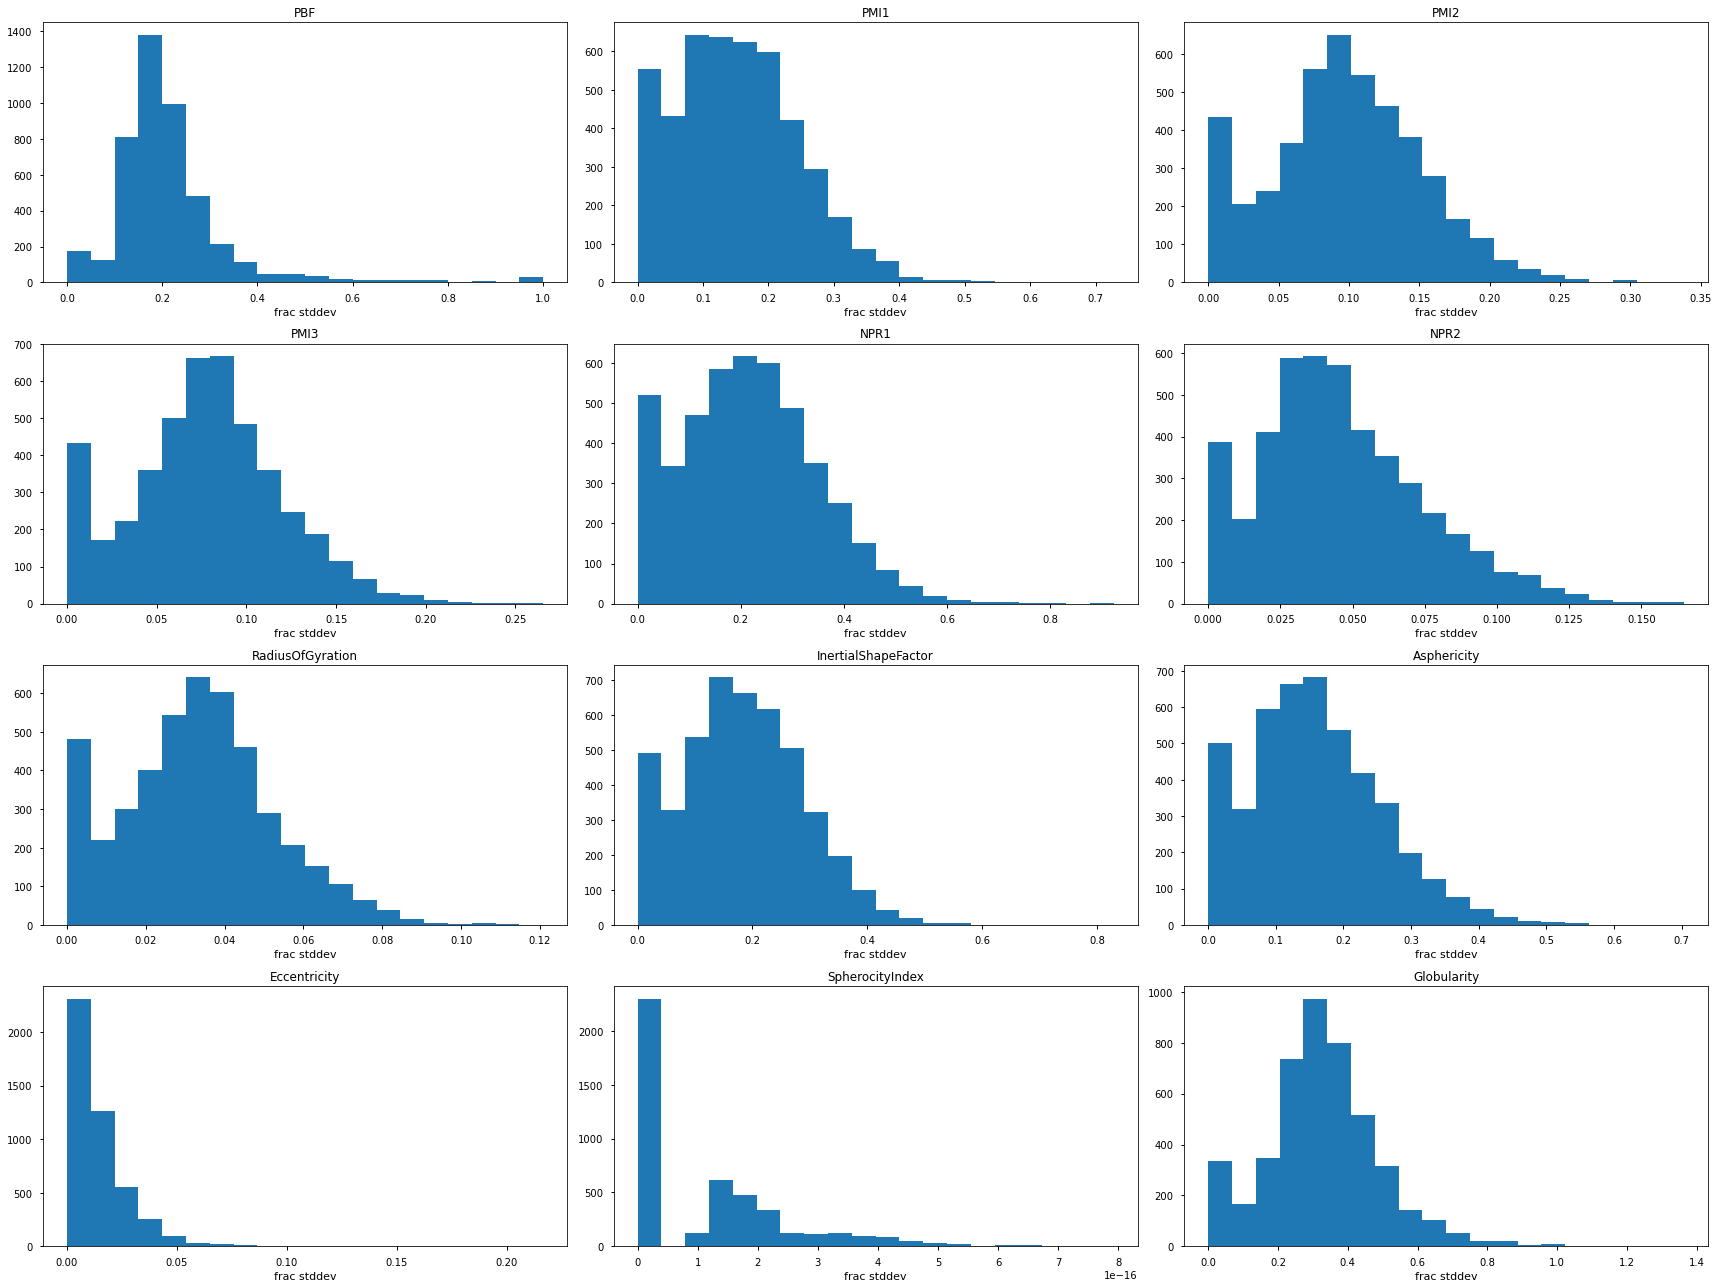

In [35]:
ndescrs = len(descr_accum2.keys())
ncols = 3
nrows = ndescrs//ncols
if ndescrs % ncols:
    nrows += 1
figsize(nrows*6,ncols*6)

dnms = list(descr_accum2.keys())
for i in range(ndescrs):
    subplot(nrows,ncols,i+1)
    hist([x[-1] for x in descr_accum2[dnms[i]]],bins=20);
    title(dnms[i]);
    xlabel('frac stddev');
tight_layout();

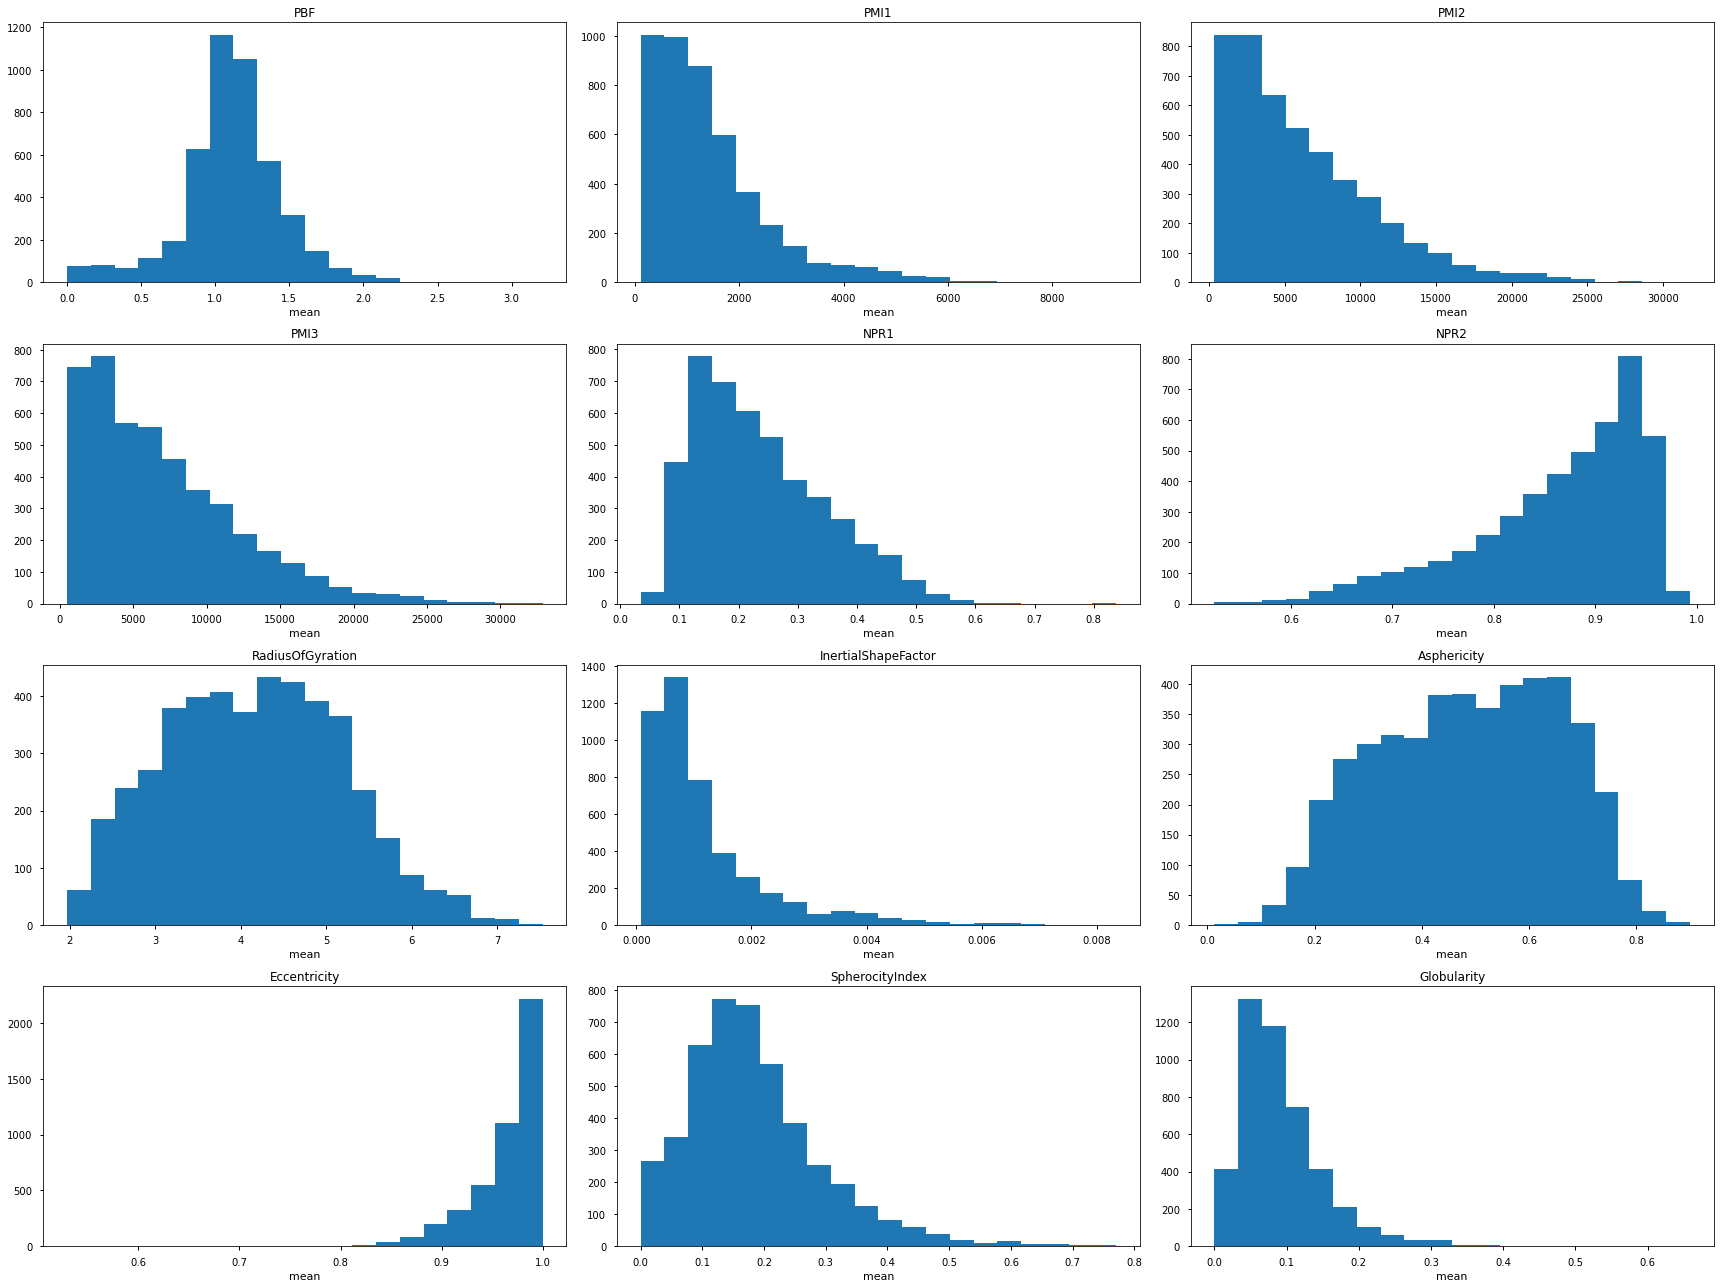

In [37]:
ndescrs = len(descr_accum2.keys())
ncols = 3
nrows = ndescrs//ncols
if ndescrs % ncols:
    nrows += 1
figsize(nrows*6,ncols*6)

dnms = list(descr_accum2.keys())
for i in range(ndescrs):
    subplot(nrows,ncols,i+1)
    hist([x[0] for x in descr_accum2[dnms[i]]],bins=20);
    title(dnms[i]);
    xlabel('mean');
tight_layout();

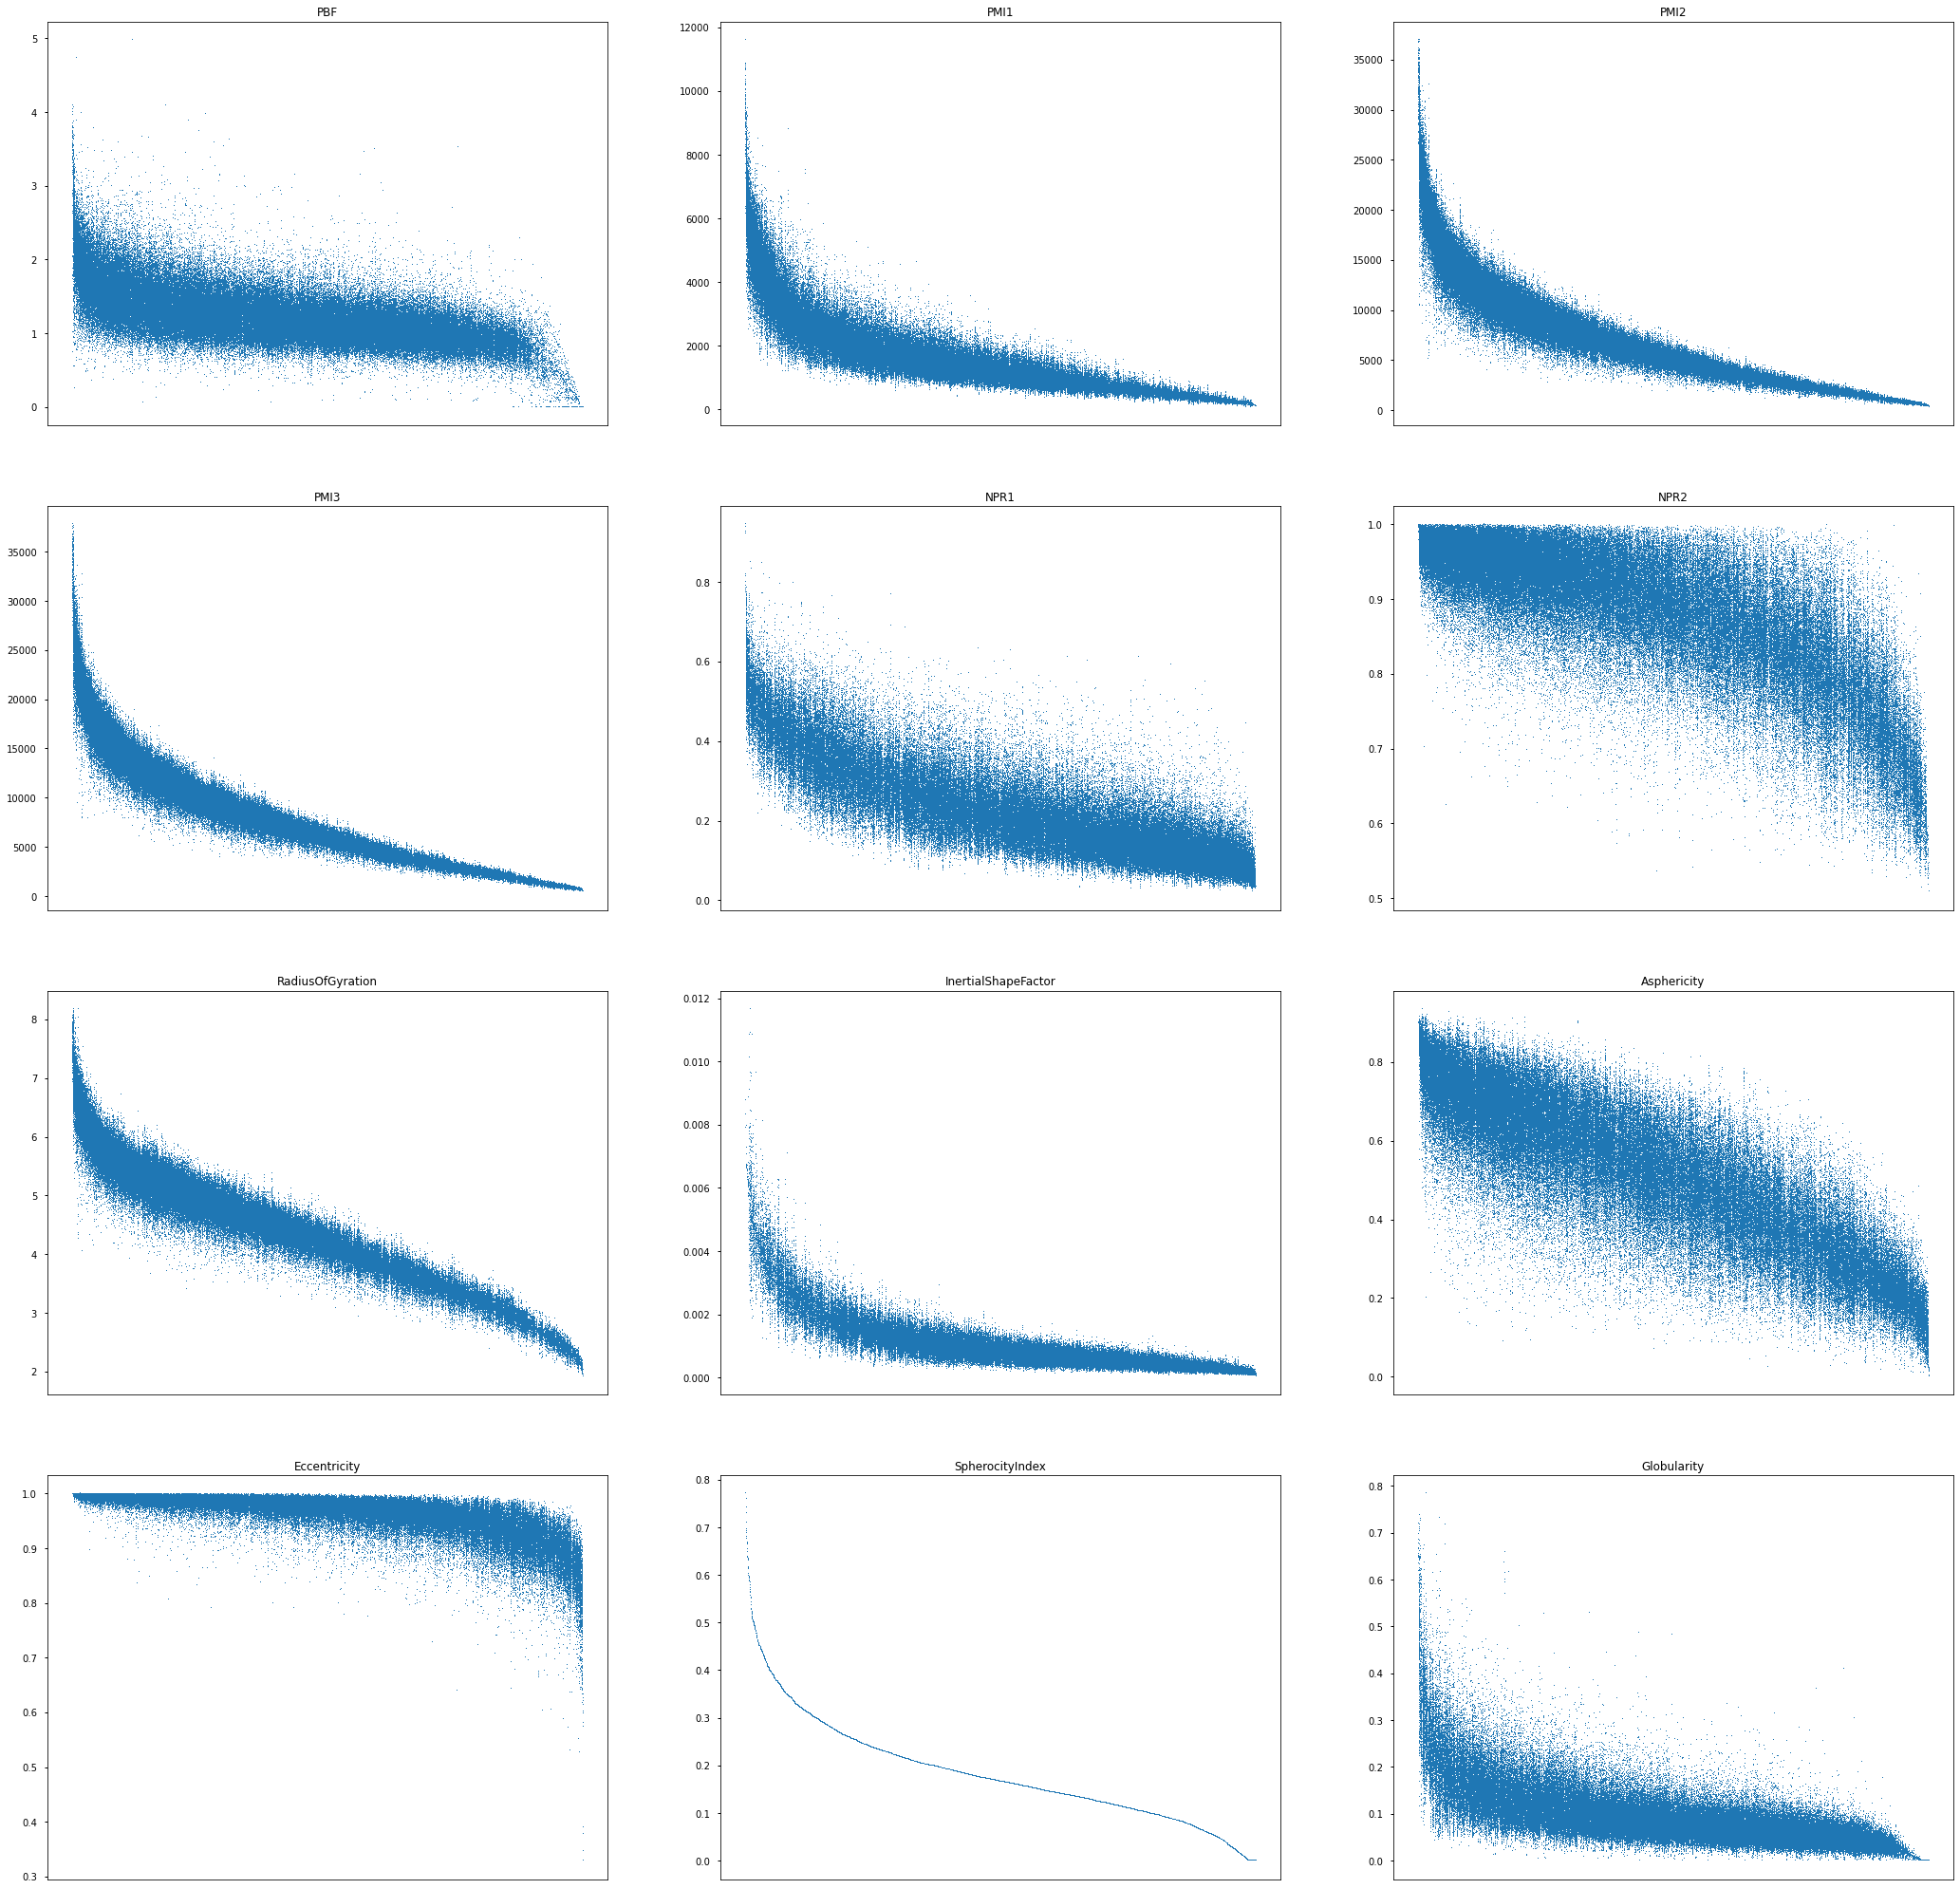

In [82]:
ndescrs = len(descr_accum2.keys())
ncols = 3
nrows = ndescrs//ncols
if ndescrs % ncols:
    nrows += 1
figsize(nrows*9,ncols*12)

dnms = list(descr_accum2.keys())

descr_accum_by_mol = defaultdict(list)
for k in accum3d:
    laccum = accum3d[k]
    for descr in laccum:
        descr_accum_by_mol[descr].append(laccum[descr])

for i in range(ndescrs):
    ax = subplot(nrows,ncols,i+1)
    vs = sorted([(y,x) for x,y in enumerate(descr_accum2[dnms[i]])],reverse=True)
    dvals = []
    xvals = []
    for j,(mean,idx) in enumerate(vs):
        molvs = descr_accum_by_mol[dnms[i]][idx]
        xvals.extend([j]*len(molvs))
        dvals.extend(molvs)
    #hexbin(xvals,dvals,cmap='Blues',bins='log')
    scatter(xvals,dvals,marker=',',lw=0,s=1)
    #plot(range(len(vs)),[x[0][0] for x in vs]);
    ax.tick_params(axis='x',which='both',top=False,bottom=False,labelbottom=False)
    #errorbar(range(len(vs)),[x[0] for x in vs],yerr=[x[1] for x in vs]);
    title(dnms[i]);
    #ylabel('frac stddev');
#tight_layout();

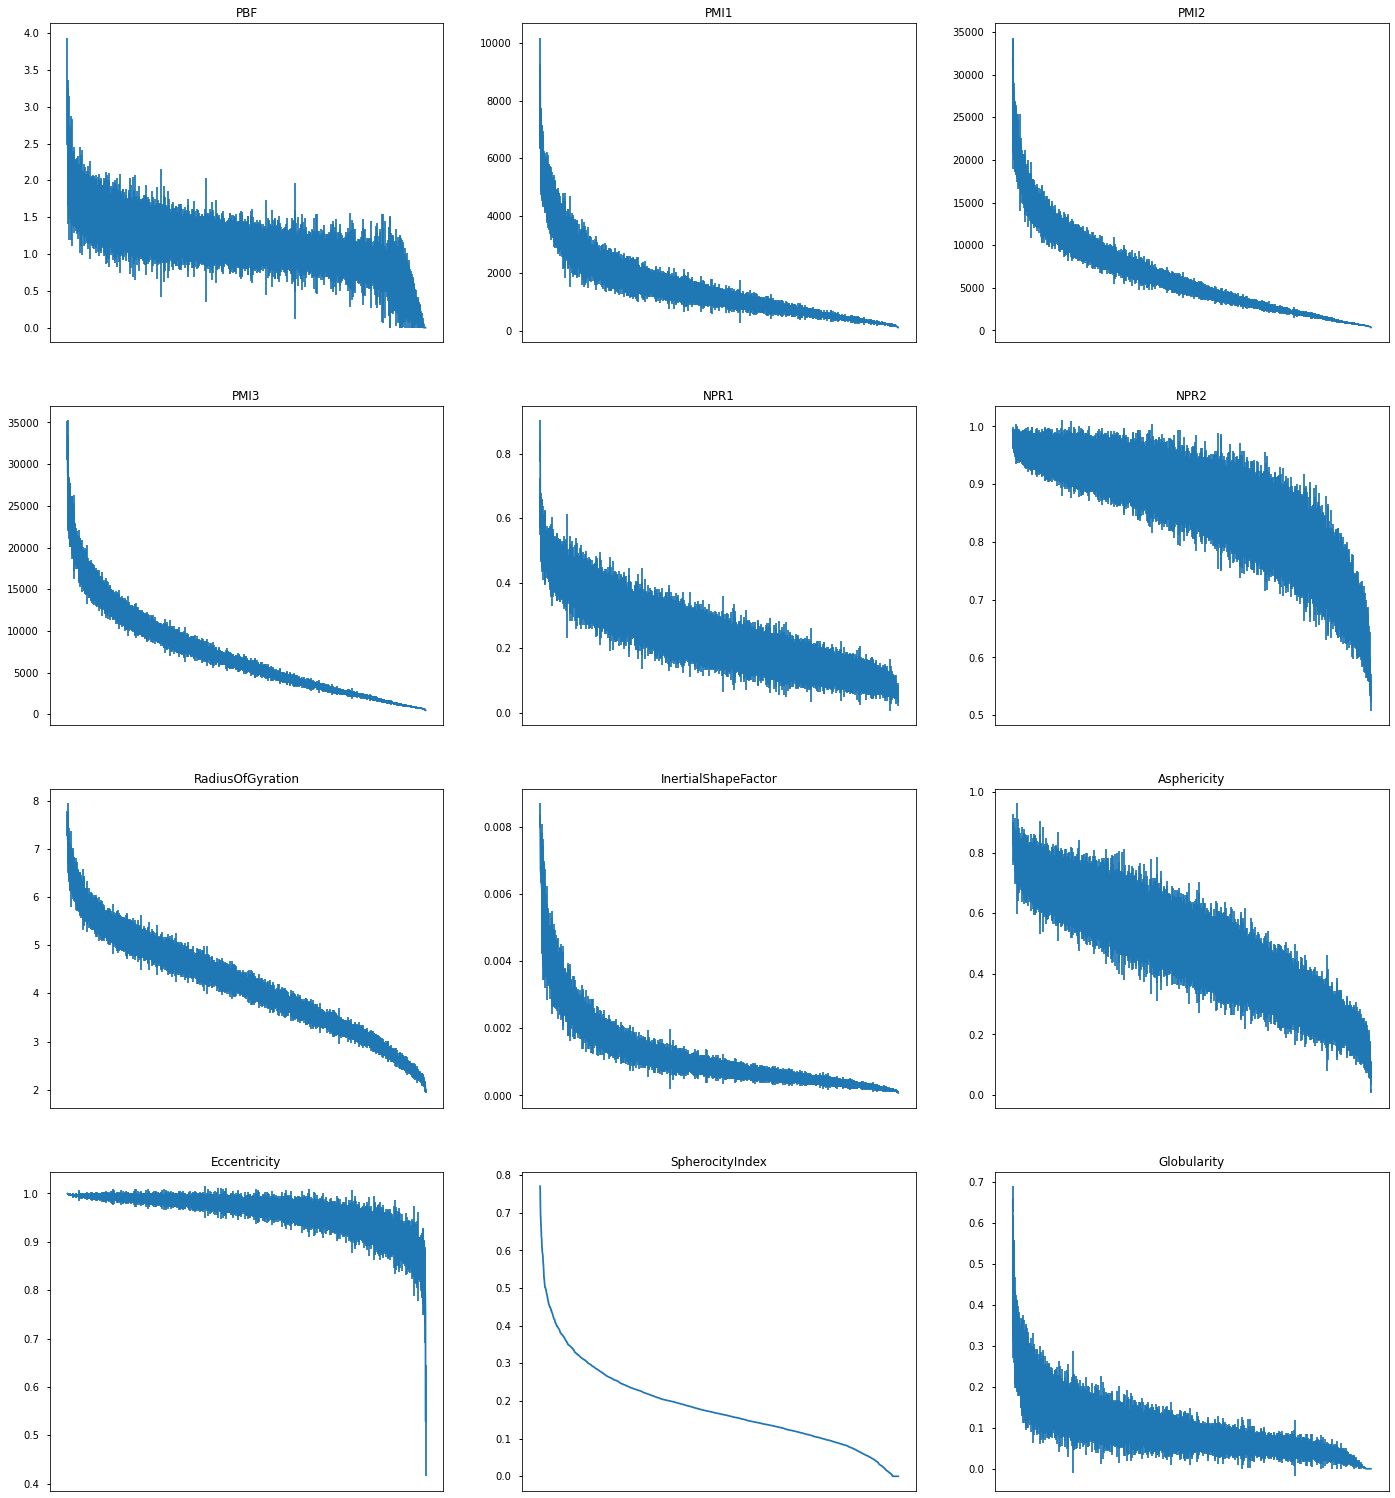

In [73]:
ndescrs = len(descr_accum2.keys())
ncols = 3
nrows = ndescrs//ncols
if ndescrs % ncols:
    nrows += 1
figsize(nrows*6,ncols*9)

dnms = list(descr_accum2.keys())


for i in range(ndescrs):   
    ax = subplot(nrows,ncols,i+1)
    vs = sorted(descr_accum2[dnms[i]],reverse=True)
    #plot(range(len(vs)),[x[0][0] for x in vs]);
    ax.tick_params(axis='x',which='both',top=False,bottom=False,labelbottom=False)
    errorbar(range(len(vs)),[x[0] for x in vs],yerr=[x[1] for x in vs]);
    title(dnms[i]);
    #ylabel('frac stddev');
#tight_layout();